In [62]:
# Name: Zeyun Wu
# Date: July 8th 2019

import numpy as np
import random
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import ToyQ2
from ToyQ2 import *

## Load real data

In [63]:
df = pd.read_csv('UH_RL_rats.csv')
df = df.drop(df.columns[[range(24)]],axis=1)
subjects = df['subject'].unique()

FileNotFoundError: [Errno 2] File b'UH_RL_rats.csv' does not exist: b'UH_RL_rats.csv'

In [ ]:
df.head()

In [ ]:
# divide df into 5 dfs according to session
# '1,11,16,6,Best'
session = df['session'].unique()
df_1 = df[df['session']=='1']
df_11 = df[df['session']=='11']
df_16 = df[df['session']=='16']
df_6 = df[df['session']=='6']
df_best = df[df['session']=='Best']
df_list = [df_1,df_11,df_16,df_6,df_best]

In [ ]:
# action list, reward list, and Q list
action_list = []
reward_list = []
Q_list = []

# the k-th array in each list corresponds to (1+k%20)-th object in session[int(k/5)]
for i in range(len(session)):
    for j in range(len(subjects)):
        subj = j + 1 # subjects 1-20
        df_sess = df_list[i]
        action = np.array(df_sess['action'][df_sess['subject']==subj])
        reward = np.array(df_sess['reward'][df_sess['subject']==subj])
        Q = np.array(df_sess['Q'][df_sess['subject']==subj])
                
        action_list.append(action)
        reward_list.append(reward)
        Q_list.append(Q)



In [ ]:
len(Q_list[10])

In [ ]:
len(reward_list[10])

In [ ]:
len(action_list[10])

In [ ]:
plt.plot(Q_list[10]) #weird
plt.show()

reward_log: [37 90]
choice_log: [193 107]


-142.61712695583708

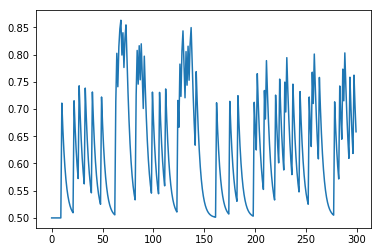

In [54]:
# demo
env=toyQ_2choice()
rat=SQFSrat(env,alphaS=0.45,alphaF=0.25,beta=2)
env,rat=train_rat(env,rat,300)
obslog=np.array(env.obslog)
choicelog=np.array(rat.choiceLog) 
print('reward_log:',np.sum(obslog,axis=0))
print('choice_log:',np.sum(choicelog,axis=0))
plt.plot(rat.lhLog)
np.log(np.prod(rat.lhLog,axis=0))

In [64]:
def plot_lh_vs_alphaS():
    fig=1
    for i in np.linspace(0.01,1,6):
        env=toyQ_2choice()
        rat=SQFSrat(env,alphaS=0.25,alphaF=i,beta=2)
        env,rat=train_rat(env,rat,300)
        obslog=np.array(env.obslog)
        choicelog=np.array(rat.choiceLog) 
        print('reward_log:',np.sum(obslog,axis=0))
        print('choice_log:',np.sum(choicelog,axis=0))
        print(np.log(np.prod(rat.lhLog,axis=0)))
        plt.figure(fig)
        plt.plot(rat.lhLog)
        fig+=1

reward_log: [42 39]
choice_log: [249  51]
-61.56578034283352
reward_log: [39 92]
choice_log: [188 112]
-150.6342593257064
reward_log: [ 42 102]
choice_log: [167 133]
-166.7250820160371
reward_log: [ 41 108]
choice_log: [172 128]
-183.86598252033147
reward_log: [ 25 106]
choice_log: [158 142]
-189.04622232055866
reward_log: [ 27 121]
choice_log: [157 143]
-196.4559201263212


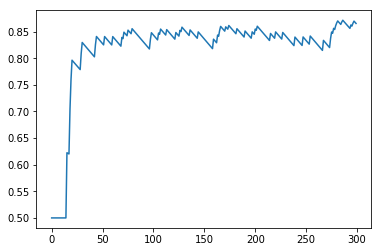

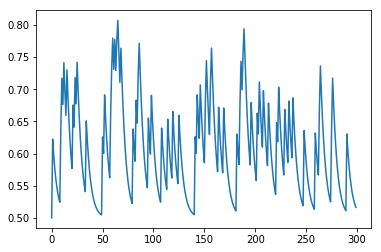

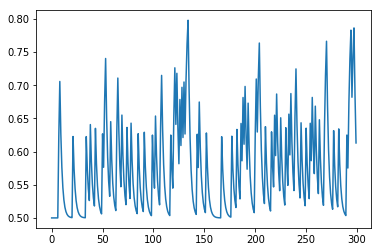

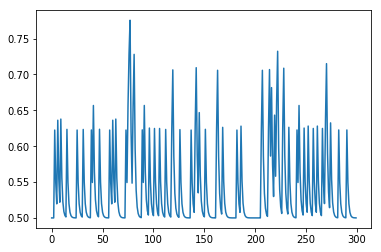

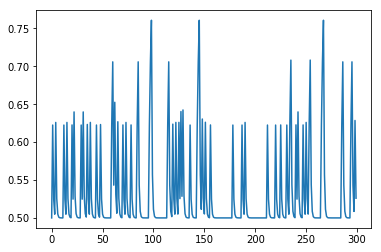

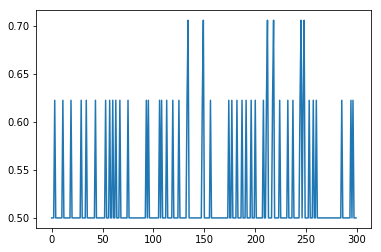

In [65]:
plot_lh_vs_alphaS()

## Functions
Distance between Q and Q_MLE

rats with single Q and two alphas for win and lose respectively

In [4]:
# parameter: action, a list of numpy arrays of action data; reward, a list of np array of reward data
# beta, sharpness of sigmoid; alpha, learning rate; Qleft, if the Q is describing the quality for the left
# return the sum of log-likelihood
###!!! suppose the reward stands for the objective reward
def neg_log_likelihood_sigQ(alpha,beta,actions,rewards,Q=0,gamma=0,Qleft=True): 
    n = len(actions)
    sum_ll = 0
    for i in range(n):
        turn = actions[i]
        rew = rewards[i]
        if turn == 1:
            Q = Q + alpha*(rew - Q + gamma*np.max(Q))
        else:
            Q = Q - alpha*(rew - Q + gamma*np.max(Q))

        if np.array_equal(turn,np.array([1,0])):
            prob = 1/(np.exp(0-beta*Q)+1)
        else:
            prob = 1 - 1/(np.exp(0-beta*Q)+1)
        
        sum_ll = sum_ll - np.log(prob + np.exp(0-8)) # add a smoother to avoid warnings
    
    return sum_ll

In [5]:
def neg_log_likelihood_sigQ_2alpha_real(alphaG,alphaL,beta,actions,rewards,Q=0,gamma=0,Qleft=True): 
    n = len(actions)
    sum_ll = 0
    for i in range(n):
        turn = actions[i]
        rew = rewards[i]
        
        if int(turn) == 2 & int(rew) == 1:
            rew = 0
            Q = Q + alphaG*(rew - Q + gamma*np.max(Q))
        elif int(turn) == 2 & int(rew) == 0:
            rew = 1
            Q = Q + alphaL*(rew - Q + gamma*np.max(Q))
        elif int(turn) == 1 & int(rew) == 1:
            rew = 1
            Q = Q - alphaG*(rew - Q + gamma*np.max(Q))
        else:
            rew = 0
            Q = Q + alphaL*(rew - Q + gamma*np.max(Q))
        
        if np.array_equal(turn,np.array([1,0])):
            prob = 1/(np.exp(0-beta*Q)+1)
        else:
            prob = 1 - 1/(np.exp(0-beta*Q)+1)
        
        sum_ll = sum_ll - np.log(prob + np.exp(0-8)) # add a smoother to avoid warnings
    
    return sum_ll

In [7]:
# params = [alphaG0,alphaL0,beta0]
# args = [actions,rewards]
def helper_func_2alpha(params,args,simulated=True):
    alphaG0 = params[0]
    alphaL0 = params[1]
    beta0 = params[2]
    actions = args[0]
    rewards = args[1]
    
    if simulated:
        sum_ll = neg_log_likelihood_sigQ_2alpha_simulated(alphaG0,alphaL0,beta0,actions,rewards)
    else:
        sum_ll = neg_log_likelihood_sigQ_2alpha_real(alphaG0,alphaL0,beta0,actions,rewards)
        
    
    return sum_ll

In [8]:
# function that estimates the maximum-likelihood beta_hat numerically
# parameters: actions, a numpy array recording action of agent in each turn; beta is the parameter in density func
# return minimization summary and print beta_hat
def MLE_2alpha(actions,rewards,alphaG0,alphaL0,beta0):
    initial_guess = [alphaG0,alphaL0,beta0]
    args = [actions,rewards]
    bounds = ((0,1),(0,1),(0,10*beta0))
    result = minimize(helper_func_2alpha,initial_guess,args=args,bounds = bounds)
    if(result.success):
        #print(result.message)
        #print('The MLE for beta is', result.x)
        #print('Iteration =', result.nit)
        a=0
    else:
        print('The optimization did not converge, beta0 equals', beta0,', and alphaG0 equals',alphaG0)
    return result
    
    

In [9]:
# return mse between simulated Q and Q_hat calculated with optimal beta from MLE
def Q_distance_2alpha(iteration,alphaG0,alphaL0,beta0):
    env = ToyQ2.toyQ_2choice()
    rat = ToyQ2.SQFSrat(env, alphaF=alphaL0,alphaS=alphaG0, beta=beta0)
    env,rat = ToyQ2.train_rat(env,rat,iteration)
    
    Q = np.array(rat.Qlog)
    actions = rat.choiceLog
    rewards = env.obslog
    
    result = MLE_2alpha(actions,rewards,alphaG0,alphaL0,beta0)
    alphaG_hat = result.x[0]
    alphaL_hat = result.x[1]
    beta_hat = result.x[2]
    
    rat_hat = ToyQ2.SQFSrat(env,alphaF=alphaL_hat,alphaS=alphaG_hat, beta=beta_hat)
    env,rat_hat = ToyQ2.train_rat(env,rat_hat,iteration)
    Q_hat = np.array(rat_hat.Qlog)
    
    #Q[0]=[0,0] does not matter
    mse = np.linalg.norm(Q-Q_hat)**2/iteration 
    #axis=None perform mean elementwise   (np.square(Q-Q_hat)).mean(axis=None)*2
    
    return mse
    
    

In [10]:
#test
Q_distance_2alpha(300,0.2,0.2,2)

0.054090291792456606

# MLE on real data

Suppose actions and rewards are exactly same as the real experiment, use the alphas and beta in the dataset and calculate the mean squared error between Q in dataset and MLE Q

Also suppose the action function is sigmoid

In [11]:
# load data
df = pd.read_csv('UH_RL_rats.csv')
df = df.drop(df.columns[[range(24)]],axis=1)
subjects = df['subject'].unique()

FileNotFoundError: [Errno 2] File b'UH_RL_rats.csv' does not exist: b'UH_RL_rats.csv'

In [12]:
# divide df into 5 dfs according to session
# '1,11,16,6,Best'
session = df['session'].unique()
df_1 = df[df['session']=='1']
df_11 = df[df['session']=='11']
df_16 = df[df['session']=='16']
df_6 = df[df['session']=='6']
df_best = df[df['session']=='Best']
df_list = [df_1,df_11,df_16,df_6,df_best]

NameError: name 'df' is not defined

In [13]:
# action list, reward list, and Q list
action_list = []
reward_list = []
Q_list = []
alphaG_list = []
alphaL_list = []
beta_list = []

# the k-th array in each list corresponds to (1+k%20)-th object in session[int(k/5)]
for i in range(len(session)):
    for j in range(len(subjects)):
        subj = j + 1 # subjects 1-20
        df_sess = df_list[i]
        action = np.array(df_sess['action'][df_sess['subject']==subj])
        reward = np.array(df_sess['reward'][df_sess['subject']==subj])
        Q = np.array(df_sess['Q'][df_sess['subject']==subj])
        alphaG = np.unique(df_sess['alpha_gain'][df_sess['subject']==subj])
        alphaL = np.unique(df_sess['alpha_loss'][df_sess['subject']==subj])
        beta = np.unique(df_sess['beta'][df_sess['subject']==subj])
                
        action_list.append(action)
        reward_list.append(reward)
        Q_list.append(Q)
        alphaG_list.append(alphaG)
        alphaL_list.append(alphaL)
        beta_list.append(beta)


NameError: name 'session' is not defined

In [14]:
df.head()

NameError: name 'df' is not defined

In [18]:
#calculate mean square error between Qlog and Q_hat
#return both mle result and mse
def simple_Q_distance(alphaG0,alphaL0,beta0,actions,rewards,Qlog):
    iteration = len(Qlog)
    
    MLE_result = MLE_2alpha(actions,rewards,alphaG0,alphaL0,beta0)
    alphaG_hat = MLE_result.x[0]
    alphaL_hat = MLE_result.x[1]
    beta_hat = MLE_result.x[2]
    
    #get Q_hat from simulation
    env = ToyQ2.toyQ_2choice()
    rat_hat = ToyQ2.SQFSrat(env,alphaF=alphaL_hat,alphaS=alphaG_hat, beta=beta_hat)
    env,rat_hat = ToyQ2.train_rat(env,rat_hat,iteration)
    Q_hat = np.array(rat_hat.Qlog)
    
    Q_hat = Q_hat[:-1] # the last Q was not used in deciding the rat's action
    
    
    mse = np.linalg.norm(Qlog-Q_hat)**2/iteration 
    return MLE_result,mse
    
    

In [19]:
#demo
mle,mse = simple_Q_distance(0.139603,1.0,20.0,action_list[0],reward_list[0],Q_list[0])

IndexError: list index out of range

In [20]:
mle

NameError: name 'mle' is not defined

In [21]:
# check if all alphas and beta are MLE result
truth_list = []
mse_list = []
for i in range(len(alphaG_list)):
    mle,mse = simple_Q_distance(alphaG_list[i][0],alphaL_list[i][0],beta_list[i][0],action_list[i],reward_list[i],
                                Q_list[i])
    val = abs(mle.x[0] - alphaG_list[i][0])/mle.x[0] < 0.1
    val = val and abs(mle.x[1] - alphaL_list[i][0])/mle.x[1] < 0.1
    val = val and abs(mle.x[2] - beta_list[i][0])/mle.x[2] <0.2
    
    truth_list.append(val)
    mse_list.append(mse)

In [22]:
df.head()

NameError: name 'df' is not defined

## Simulated rats with 2 alphas

In [23]:
env = ToyQ2.toyQ_2choice()
rat = ToyQ2.SQFSrat(env,alphaF=0.3,alphaS=0.2, beta=4)
env,rat = ToyQ2.train_rat(env,rat,100)
Q = np.array(rat.Qlog)

actions = rat.choiceLog
rewards = env.obslog

In [30]:
MLE_2alpha(actions,rewards,0.2,0.3,4)

      fun: 66.07360694327687
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.11349664e+01, 4.68958206e-05, 0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 88
      nit: 17
   status: 0
  success: True
        x: array([0.        , 0.02879853, 8.44500691])

In [25]:
neg_log_likelihood_sigQ_2alpha_simulated(0.2,0.3,4,actions,rewards)

76.6834931459671

In [26]:
helper_func_2alpha(params=(0.2,0.3,4),args=(actions,rewards))

76.6834931459671

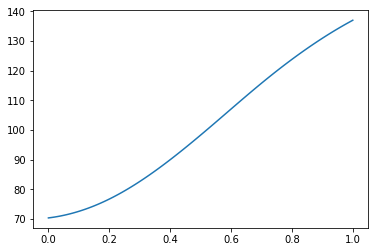

In [27]:
# plot likelihood versus alphaG
alphaG_list = np.linspace(0,1,100)
ll_list = [neg_log_likelihood_sigQ_2alpha_simulated(i,0.3,4,actions,rewards) for i in alphaG_list]
plt.plot(alphaG_list,ll_list)
plt.show()

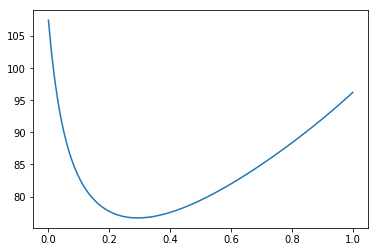

In [28]:
# plot likelihood versus alphaL
alphaL_list = np.linspace(0,1,100)
ll_list = [neg_log_likelihood_sigQ_2alpha_simulated(0.2,i,4,actions,rewards) for i in alphaL_list]
plt.plot(alphaL_list,ll_list)
plt.show()

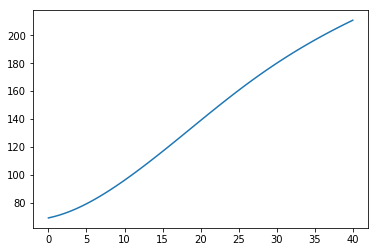

In [29]:
# plot likelihood versus beta
beta_list = np.linspace(0,40,100)
ll_list = [neg_log_likelihood_sigQ_2alpha_simulated(0.2,0.3,i,actions,rewards) for i in beta_list]
plt.plot(beta_list,ll_list)
plt.show()